In [1]:
import sys
import os

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import patches

import cv2
import torch
import torchvision
from torchvision import datasets, models, transforms
from torch import nn
import albumentations as A


In [2]:
from albumentations.pytorch.transforms import ToTensorV2
from torch.utils import data as torch_data
from torchvision import transforms as T
import torch.nn.functional as F

from torch.utils.data import Dataset
from PIL import Image 
from xml.etree import ElementTree as ET
import glob 
from torch.utils.data import DataLoader
from copy import deepcopy

- 학습률 그대로, 전처리 여러가지 추가, 드랍아웃 추가(3개), 배치사이즈16 
===> 정확도 0.017에서 시작해서 그만 둠

- 학습률 그대로, 전처리 추가, 드랍아웃 없이, 배치사이즈16
===> 전처리 추가 했을 때 과적합 줄이는 효과 기대, 실제로 과적합은 줄어드는 줄 알았으나... 여전히 과적합 심하고 loss와 정확도가 별로임

- 학습률 0.001, 전처리 추가, 드랍아웃 없이 
===> loss 줄이는 효과 기대

- 학습률 0.001, 전처리 추가, 드랍아웃 1개 추가 

- 학습률 0.001, 배치사이즈 8, 전처리추가

In [3]:
%pwd

'/kaggle/working'

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
images = '/kaggle/input/stanford-dogs-dataset/images/'
annotations = '/kaggle/input/stanford-dogs-dataset/annotations'

In [4]:
def get_image(annot):
    img_path = '/kaggle/input/stanford-dogs-dataset/images/Images/'
    file = annot.split('/')
    img_filename = img_path + file[-2]+'/'+file[-1]+'.jpg'
    return img_filename

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: DeprecationWarning: ANTIALIAS is deprecated and will be removed in Pillow 10 (2023-07-01). Use LANCZOS or Resampling.LANCZOS instead.
  # This is added back by InteractiveShellApp.init_path()


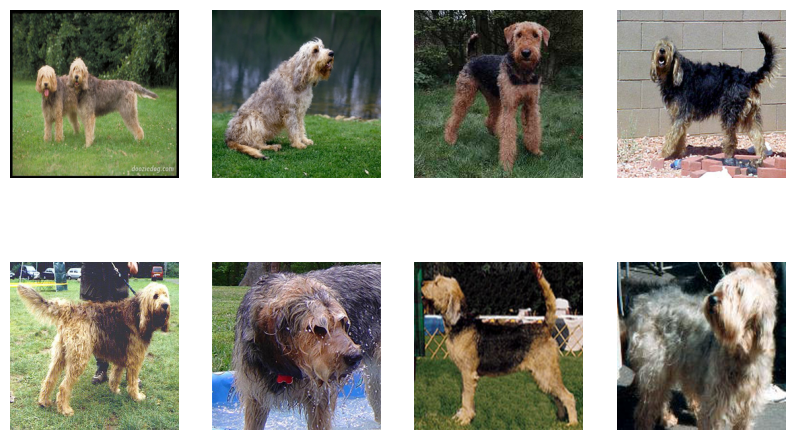

In [5]:
# 전처리 전 시각화 
annotations = glob.glob('/kaggle/input/stanford-dogs-dataset/annotations/Annotation/*/*')

plt.figure(figsize=(10,6))
for i in range(8):
    plt.subplot(2,4,i+1)
    plt.axis("off")
    dog = get_image(annotations[i])
    
    im = Image.open(dog)
    im = im.resize((256,256), Image.ANTIALIAS)
    plt.imshow(im)

In [5]:
root_dir = '/kaggle/input/stanford-dogs-dataset/'
img_dir = '/images/Images/'
annot_dir = '/annotations/Annotation/'

In [6]:
import os

labels_map = {}
for i, item in enumerate(os.listdir(root_dir + img_dir)):
    sub_folder = os.path.join(root_dir + img_dir, item)
    labels_map[sub_folder.split('-', maxsplit=3)[-1]] = i

In [7]:
def img_crop(annot_path, img):
    tree = ET.parse(annot_path)
    obj = tree.find('./object')
    bndbox = obj.find('bndbox')

    # 강아지 종류
    species = obj.find('name').text

    # 이미지에서의 강아지 위치
    xmin = int(bndbox.find('xmin').text)
    ymin = int(bndbox.find('ymin').text)
    xmax = int(bndbox.find('xmax').text)
    ymax = int(bndbox.find('ymax').text)

    cropped_img = img[ymin:ymax, xmin:xmax]
    
    label = labels_map.get(species)

    return label, cropped_img

In [8]:
class DogsDataset(Dataset):
    def __init__(self, annot_dir, img_dir, transform=None):
        annot_dir = glob.glob(root_dir + annot_dir + '*/*')
        img_dir = glob.glob(root_dir + img_dir + '*/*.jpg')
        self.annot_dir = sorted(annot_dir)
        self.img_dir = sorted(img_dir)
        self.transform = transform
   
    def __len__(self):
        return len(self.img_dir)
        
    def __getitem__(self, idx):
        annot_path = self.annot_dir[idx]
        img_path = self.img_dir[idx]
        
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        label, img = img_crop(annot_path, img)
        
        if self.transform is not None:
            img = self.transform(image=img)
            img['label'] = label
            return img
            
        sample = {'image': img, 'label': label}
        return sample

In [10]:
augmentor = A.OneOf([
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.CLAHE(p=0.5)])

In [11]:
data_transform = A.Compose([A.Resize(224, 224), augmentor, A.Normalize(), ToTensorV2()])
# 밝기, 가로뒤집, 세로 뒤집 셋 중하나 랜덤으로 

In [12]:
image_dataset = DogsDataset(annot_dir ='/annotations/Annotation/',
                            img_dir ='/images/Images/', transform=data_transform)

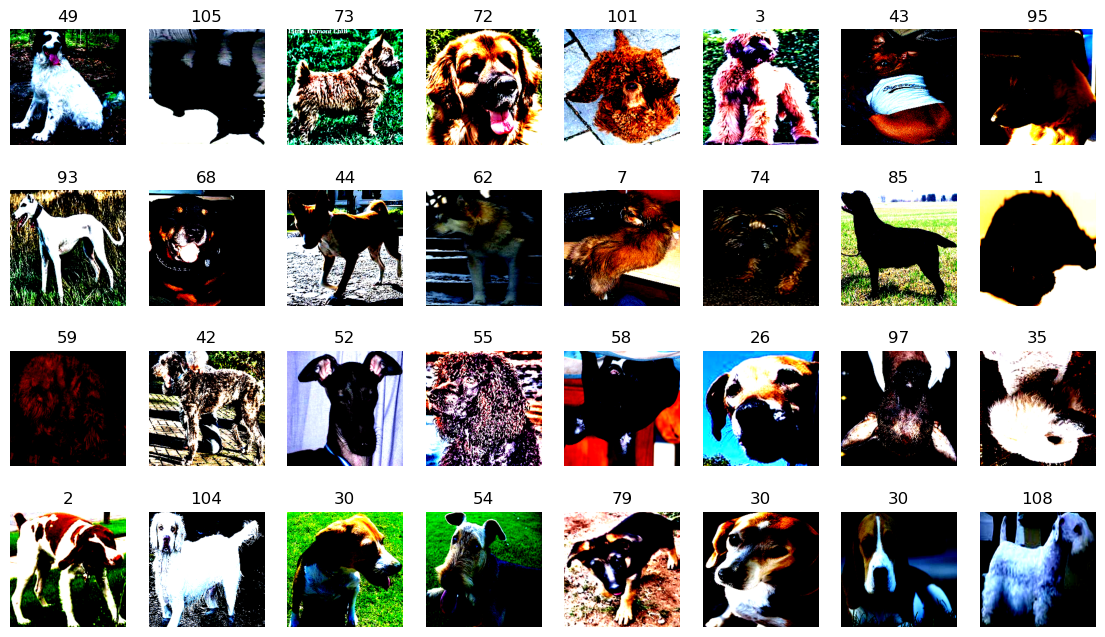

In [13]:
# 전처리 후 시각화
figure, axes = plt.subplots(nrows=4, ncols=8, figsize=(14, 8))
axes = axes.flatten()

for i in range(32):
    rand_i = np.random.randint(0, len(image_dataset))
    image, label= image_dataset[rand_i]['image'].permute(1, 2, 0), image_dataset[rand_i]['label']
    axes[i].axis('off')
    axes[i].imshow(image)
    axes[i].set_title(label)

In [14]:
len(image_dataset)

20580

In [15]:
image_dataset[0]

{'image': tensor([[[-1.0048, -1.0048, -1.0390,  ...,  0.4508,  0.5022,  0.2453],
          [-1.0219, -1.0390, -1.0733,  ..., -0.1314, -0.3027, -0.4739],
          [-1.0390, -1.0562, -1.0904,  ..., -0.1314, -0.3883, -0.6965],
          ...,
          [ 2.2489,  2.2489,  2.2489,  ..., -2.0323, -2.0152, -1.9124],
          [ 2.2489,  2.2489,  2.2489,  ..., -2.0152, -2.0494, -1.9638],
          [ 2.2489,  2.2489,  2.2489,  ..., -2.0494, -2.0837, -2.0837]],
 
         [[-1.1604, -1.1604, -1.1954,  ...,  0.8529,  0.9405,  0.6954],
          [-1.1779, -1.1954, -1.2304,  ...,  0.2052,  0.0301, -0.1099],
          [-1.1954, -1.2129, -1.2479,  ...,  0.1702, -0.0749, -0.3550],
          ...,
          [ 2.4286,  2.4286,  2.4286,  ..., -1.9482, -1.9307, -1.8256],
          [ 2.4286,  2.4286,  2.4286,  ..., -1.9307, -1.9657, -1.8782],
          [ 2.4286,  2.4286,  2.4286,  ..., -1.8957, -1.9307, -1.9307]],
 
         [[-0.9853, -1.0027, -1.0201,  ...,  0.3045,  0.3742,  0.1128],
          [-1.0027,

In [19]:
image_dataset[0]['image']

tensor([[[ 2.2489,  2.2489,  2.2489,  ..., -2.0494, -2.0837, -2.0837],
         [ 2.2489,  2.2489,  2.2489,  ..., -2.0152, -2.0494, -1.9638],
         [ 2.2489,  2.2489,  2.2489,  ..., -2.0323, -2.0152, -1.9124],
         ...,
         [-1.0390, -1.0562, -1.0904,  ..., -0.1314, -0.3883, -0.6965],
         [-1.0219, -1.0390, -1.0733,  ..., -0.1314, -0.3027, -0.4739],
         [-1.0048, -1.0048, -1.0390,  ...,  0.4508,  0.5022,  0.2453]],

        [[ 2.4286,  2.4286,  2.4286,  ..., -1.8957, -1.9307, -1.9307],
         [ 2.4286,  2.4286,  2.4286,  ..., -1.9307, -1.9657, -1.8782],
         [ 2.4286,  2.4286,  2.4286,  ..., -1.9482, -1.9307, -1.8256],
         ...,
         [-1.1954, -1.2129, -1.2479,  ...,  0.1702, -0.0749, -0.3550],
         [-1.1779, -1.1954, -1.2304,  ...,  0.2052,  0.0301, -0.1099],
         [-1.1604, -1.1604, -1.1954,  ...,  0.8529,  0.9405,  0.6954]],

        [[ 2.6400,  2.6400,  2.6400,  ..., -1.6824, -1.7173, -1.7173],
         [ 2.6400,  2.6400,  2.6400,  ..., -1

In [20]:
image_dataset[0]['image'].shape

torch.Size([3, 224, 224])

In [16]:
d = image_dataset[0]
d['label']

71

In [11]:
len(image_dataset)

20580

In [18]:
#total_label = [data['label'] for data in image_dataset]

In [14]:
# total_label =[]
# for i in range(len(image_dataset)):
#     total_label.append(image_dataset[i]['label'])

KeyboardInterrupt: 

In [ ]:
# total_label=[]
# for data in image_dataset:
#     total_label.append(data['label'])

****데이터셋 나누기****

In [16]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

total_label = [data['label'] for data in image_dataset]

trainset_idx, testset_idx = train_test_split(range(len(image_dataset)),
                test_size=0.2, random_state=42, shuffle=True, stratify=total_label)

# 전체 데이터 셋이서 train과 test로 나누기
train_set = Subset(image_dataset, trainset_idx)
test_set = Subset(image_dataset, testset_idx)

# train label
train_label = [data['label'] for data in train_set]

# train idx와 valid idx
trainset_idx, validset_idx = train_test_split(range(len(trainset_idx)),
                test_size=0.2, random_state=42, shuffle=True, stratify=train_label)

# train set에서 train과 valid로 나누기
from torch.utils.data import Subset
trainset = Subset(train_set, trainset_idx)
validset = Subset(train_set, validset_idx)

In [17]:
print(type(trainset), len(trainset))
print(type(validset), len(validset))
print(type(test_set), len(test_set))

<class 'torch.utils.data.dataset.Subset'> 13171
<class 'torch.utils.data.dataset.Subset'> 3293
<class 'torch.utils.data.dataset.Subset'> 4116


29635

In [23]:
trainset[0]['image'].shape

torch.Size([3, 224, 224])

In [24]:
validset[0]['image'].shape

torch.Size([3, 224, 224])

In [25]:
test_set[0]['image'].shape

torch.Size([3, 224, 224])

****ResNet50 모델**** 

In [18]:
batch_size = 16 # 100 -> 16
# dataloader = DataLoader(데이터셋, 배치사이즈, 셔플여부.....)
trainloader = DataLoader(trainset, batch_size=batch_size, shuffle=True) # 훈련용 13171개의 데이터를 100개씩 준비
validloader = DataLoader(validset, batch_size=batch_size, shuffle=False) # 검증용 10000개의 데이터를 100개씩 준비
testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False) # 테스트용 10000개의 데이터를 100개씩 준비

In [19]:
print(type(trainloader), len(trainloader))
print(type(validloader), len(validloader))
print(type(testloader), len(testloader))

<class 'torch.utils.data.dataloader.DataLoader'> 824
<class 'torch.utils.data.dataloader.DataLoader'> 206
<class 'torch.utils.data.dataloader.DataLoader'> 258


In [20]:
13171/16, 3293/16, 4116/16

(823.1875, 205.8125, 257.25)

In [21]:
train_iter = iter(trainloader)
batch = next(train_iter)
batch['image'].size(), batch['label'].shape

(torch.Size([16, 3, 224, 224]), torch.Size([16]))

In [22]:
import torch.nn as nn # 파이토치에서 제공하는 다양한 계층 (Linear Layer, ....)
import torch.optim as optim # 옵티마이저 (경사하강법...)
import torch.nn.functional as F # 파이토치에서 제공하는 함수(활성화 함수...)

**** conv block 별 사이즈 확인****

In [26]:
# conv1
conv1 = nn.Sequential(
    # BatchNorm 계층은 편향값의 효과를 보완해주므로 관례상 생략
                            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False), # [16, 65, 112, 112]
                            nn.BatchNorm2d(num_features=64),
                            nn.ReLU(),                        
                            nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                            ) # [16, 64, 56, 56]
conv1_out = conv1(batch['image'])                                     
conv1_out.shape           

torch.Size([16, 64, 56, 56])

In [41]:
# conv2_x      
shortcut2 = nn.Sequential(
                                nn.Conv2d(in_channels=64, out_channels=256, kernel_size=1, stride=1), 
                                nn.BatchNorm2d(num_features=256)                                  
                              )  
conv2_x = nn.Sequential(
                              ResBlock(in_channels=64, out_channels=64, shortcut=shortcut2, stride=1),                                 
                              ResBlock(in_channels=256, out_channels=64, shortcut=None, stride=1),
                              ResBlock(in_channels=256, out_channels=64, shortcut=None, stride=1)
                            ) # [16, 256, 56, 56]
conv2_x_out = conv2_x(conv1_out)                                     
conv2_x_out.shape          

torch.Size([16, 256, 56, 56])

In [42]:
# conv3_x
shortcut3 = nn.Sequential(
                                nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1, stride=2), 
                                nn.BatchNorm2d(num_features=512)                                  
                              )      
conv3_x = nn.Sequential(
                              ResBlock(in_channels=256, out_channels=128, shortcut=shortcut3, stride=2),
                              ResBlock(in_channels=512, out_channels=128, shortcut=None, stride=1),
                              ResBlock(in_channels=512, out_channels=128, shortcut=None, stride=1),
                              ResBlock(in_channels=512, out_channels=128, shortcut=None, stride=1)

                            ) # [16, 512, 28, 28] 
conv3_x_out = conv3_x(conv2_x_out)                                     
conv3_x_out.shape       

torch.Size([16, 512, 28, 28])

In [43]:
# conv4_x
shortcut4 = nn.Sequential(
                                nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1, stride=2), 
                                nn.BatchNorm2d(num_features=1024)                                  
                              )      
conv4_x = nn.Sequential(
                              ResBlock(in_channels=512, out_channels=256, shortcut=shortcut4, stride=2),
                              ResBlock(in_channels=1024, out_channels=256, shortcut=None, stride=1),
                              ResBlock(in_channels=1024, out_channels=256, shortcut=None, stride=1),
                              ResBlock(in_channels=1024, out_channels=256, shortcut=None, stride=1),
                              ResBlock(in_channels=1024, out_channels=256, shortcut=None, stride=1),
                              ResBlock(in_channels=1024, out_channels=256, shortcut=None, stride=1),                                                                                        
                            ) # [16, 1024, 14, 14]
conv4_x_out = conv4_x(conv3_x_out)                                     
conv4_x_out.shape 

torch.Size([16, 1024, 14, 14])

In [44]:
# conv5_x
shortcut5 = nn.Sequential(
                                nn.Conv2d(in_channels=1024, out_channels=2048, kernel_size=1, stride=2), 
                                nn.BatchNorm2d(num_features=2048)                                  
                              )    
conv5_x = nn.Sequential(
                              ResBlock(in_channels=1024, out_channels=512, shortcut=shortcut5, stride=2),
                              ResBlock(in_channels=2048, out_channels=512, shortcut=None, stride=1),
                              ResBlock(in_channels=2048, out_channels=512, shortcut=None, stride=1),                                                                
                            ) # [16, 2048, 7, 7]  
conv5_x_out = conv5_x(conv4_x_out)                                     
conv5_x_out.shape  

torch.Size([16, 2048, 7, 7])

In [45]:
avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # [16, 2048, 1, 1]  
avg_pool_out = avg_pool(conv5_x_out)
avg_pool_out.shape

torch.Size([16, 2048, 1, 1])

In [31]:
class ResBlock(nn.Module):
    def __init__(self, in_channels, out_channels, shortcut=None, stride=1): # shortcut에 계층을 설정되어 있다면 그 계층을 통과한뒤 Add
        super().__init__()

        # 1x1 conv
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.batch_norm1 = nn.BatchNorm2d(out_channels)

        # 3x3 conv 
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1) # stride=2일 경우에는 downsampling
        self.batch_norm2 = nn.BatchNorm2d(out_channels)

        # 1x1 conv
        self.conv3 = nn.Conv2d(out_channels, out_channels*4, kernel_size=1, stride=1, padding=0)
        self.batch_norm3 = nn.BatchNorm2d(out_channels*4)

        self.shortcut = shortcut
        self.stride = stride
        self.relu = nn.ReLU()

    def forward(self, x):
        identity = x.clone()
        x = self.relu(self.batch_norm1(self.conv1(x)))
        x = self.relu(self.batch_norm2(self.conv2(x)))
        x = self.batch_norm3(self.conv3(x))

        # shortcut 계층을 바깥에서 설정한것을 적용할 때
        if self.shortcut is not None:
            identity = self.shortcut(identity)

        x += identity  # x = x+identity
        
        # dropout
        #x = F.dropout(x, 0.2)
        x = self.relu(x)

        return x


In [32]:
class ResNet50(nn.Module):
    def __init__(self):
        super().__init__()
        # conv1
        self.conv1 = nn.Sequential(
                                    # BatchNorm 계층은 편향값의 효과를 보완해주므로 관례상 생략략
                                    nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=2, padding=3, bias=False),
                                    nn.BatchNorm2d(num_features=64),
                                    nn.ReLU(),                        
                                    nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                    ) # [16, 64, 56, 56]
        # conv2_x      
        self.shortcut2 = nn.Sequential(
                                        nn.Conv2d(in_channels=64, out_channels=256, kernel_size=1, stride=1), 
                                        nn.BatchNorm2d(num_features=256)                                  
                                      )              
        self.conv2_x = nn.Sequential(
                                      ResBlock(in_channels=64, out_channels=64, shortcut=self.shortcut2, stride=1),                                 
                                      ResBlock(in_channels=256, out_channels=64, shortcut=None, stride=1),
                                      ResBlock(in_channels=256, out_channels=64, shortcut=None, stride=1)
                                    ) # [16, 256, 56, 56]
        # conv3_x
        self.shortcut3 = nn.Sequential(
                                        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1, stride=2), 
                                        nn.BatchNorm2d(num_features=512)                                  
                                      )      
        self.conv3_x = nn.Sequential(
                                      ResBlock(in_channels=256, out_channels=128, shortcut=self.shortcut3, stride=2),
                                      ResBlock(in_channels=512, out_channels=128, shortcut=None, stride=1),
                                      ResBlock(in_channels=512, out_channels=128, shortcut=None, stride=1),
                                      ResBlock(in_channels=512, out_channels=128, shortcut=None, stride=1)

                                    ) # [16, 512, 28, 28]   
        # conv4_x
        self.shortcut4 = nn.Sequential(
                                        nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=1, stride=2), 
                                        nn.BatchNorm2d(num_features=1024)                                  
                                      )      
        self.conv4_x = nn.Sequential(
                                     ResBlock(in_channels=512, out_channels=256, shortcut=self.shortcut4, stride=2),
                                     ResBlock(in_channels=1024, out_channels=256, shortcut=None, stride=1),
                                     ResBlock(in_channels=1024, out_channels=256, shortcut=None, stride=1),
                                     ResBlock(in_channels=1024, out_channels=256, shortcut=None, stride=1),
                                     ResBlock(in_channels=1024, out_channels=256, shortcut=None, stride=1),
                                     ResBlock(in_channels=1024, out_channels=256, shortcut=None, stride=1),                                                                                        
                                    ) # [16, 1024, 14, 14] 
        # conv5_x
        self.shortcut5 = nn.Sequential(
                                        nn.Conv2d(in_channels=1024, out_channels=2048, kernel_size=1, stride=2), 
                                        nn.BatchNorm2d(num_features=2048)                                  
                                      )    
        self.conv5_x = nn.Sequential(
                                     ResBlock(in_channels=1024, out_channels=512, shortcut=self.shortcut5, stride=2),
                                     ResBlock(in_channels=2048, out_channels=512, shortcut=None, stride=1),
                                     ResBlock(in_channels=2048, out_channels=512, shortcut=None, stride=1),                                                                
                                    ) # [16, 2048, 7, 7]  

        self.avg_pool = nn.AdaptiveAvgPool2d((1, 1))  # [16, 2048, 1, 1]                                                                                                                              

        self.classifier = nn.Sequential(
                                    nn.Linear(in_features=2048, out_features=120),
                                    # nn.BatchNorm1d(num_features=64),
                                    # nn.ReLU(),
                                    # nn.Linear(in_features=64, out_features=2)
                                    )

    def forward(self, x):
        x = self.conv1(x) # [16, 64, 56, 56]
        x = self.conv2_x(x) # [16, 256, 56, 56]
        x = self.conv3_x(x) # [16, 512, 28, 28] 
        x = self.conv4_x(x) # [16, 1024, 14, 14] 
        x = self.conv5_x(x) # [16, 2048, 7, 7] 
        x = self.avg_pool(x) # [16, 2048, 1, 1] 

        # reshape할 형상 : (batch_size x 2048)
        # x = x.view(-1, 2048) # option 1 : view
        x = torch.flatten(x, 1) # option 2 : flatten 
        # x = x.reshape(x.shape[0], -1) # option 3 : reshape
        
        # 드랍아웃 추가 
    
        #x = F.dropout(x, 0.5)
        x = self.classifier(x)    
        return x

In [33]:
model = ResNet50()
model.to(device)
model

ResNet50(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (shortcut2): Sequential(
    (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv2_x): Sequential(
    (0): ResBlock(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (batch_norm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1))
      (batch_norm3): BatchNorm2d(256, eps=1e-05, 

In [34]:
out = model(batch['image'].to(device))
out.shape

torch.Size([16, 120])

In [38]:
for name, parameter in model.named_parameters():
    print(name, parameter.size())

conv1.0.weight torch.Size([64, 3, 7, 7])
conv1.1.weight torch.Size([64])
conv1.1.bias torch.Size([64])
shortcut2.0.weight torch.Size([256, 64, 1, 1])
shortcut2.0.bias torch.Size([256])
shortcut2.1.weight torch.Size([256])
shortcut2.1.bias torch.Size([256])
conv2_x.0.conv1.weight torch.Size([64, 64, 1, 1])
conv2_x.0.conv1.bias torch.Size([64])
conv2_x.0.batch_norm1.weight torch.Size([64])
conv2_x.0.batch_norm1.bias torch.Size([64])
conv2_x.0.conv2.weight torch.Size([64, 64, 3, 3])
conv2_x.0.conv2.bias torch.Size([64])
conv2_x.0.batch_norm2.weight torch.Size([64])
conv2_x.0.batch_norm2.bias torch.Size([64])
conv2_x.0.conv3.weight torch.Size([256, 64, 1, 1])
conv2_x.0.conv3.bias torch.Size([256])
conv2_x.0.batch_norm3.weight torch.Size([256])
conv2_x.0.batch_norm3.bias torch.Size([256])
conv2_x.1.conv1.weight torch.Size([64, 256, 1, 1])
conv2_x.1.conv1.bias torch.Size([64])
conv2_x.1.batch_norm1.weight torch.Size([64])
conv2_x.1.batch_norm1.bias torch.Size([64])
conv2_x.1.conv2.weight tor

In [35]:
learning_rate = 0.0001
# 손실함수
loss_fn = nn.CrossEntropyLoss()

# 옵티마이저(최적화함수, 예:경사하강법)
# optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# 규제의 강도 설정 weight_decay
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=0.001)

# Learning Rate Schedule
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.ReduceLROnPlateau.html

# 모니터링하고 있는 값(예:valid_loss)의 최소값(min) 또는 최대값(max) patience 기간동안 줄어들지 않을 때(OnPlateau) lr에 factor(0.1)를 곱해주는 전략
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=4, verbose=True)

In [36]:
def validate(model, validloader, loss_fn):
    total = 0   
    correct = 0
    valid_loss = 0
    valid_accuracy = 0

  # 전방향 예측을 구할 때는 gradient가 필요가 없음음
    with torch.no_grad():
        for batch in validloader:# 이터레이터로부터 next()가 호출되며 미니배치를 반환(images, labels)      
          # images, labels : (torch.Size([16, 3, 224, 224]), torch.Size([16]))
          # 0. Data를 GPU로 보내기
            images = batch['image']
            labels = batch['label']
            
            images, labels = images.to(device), labels.to(device)
            
            # 1. 입력 데이터 준비
            # not Flatten !!
            # images.resize_(images.size()[0], 784)
  
            # 2. 전방향(Forward) 예측
            logit = model(images) # 예측 점수
            _, preds = torch.max(logit, 1) # 배치에 대한 최종 예측
            # preds = logit.max(dim=1)[1] 
            correct += int((preds == labels).sum()) # 배치 중 맞은 것의 개수가 correct에 누적
            total += labels.shape[0] # 배치 사이즈만큼씩 total에 누적

            loss = loss_fn(logit, labels)
            valid_loss += loss.item() # tensor에서 값을 꺼내와서, 배치의 loss 평균값을 valid_loss에 누적

        valid_accuracy = correct / total
  
    return valid_loss, valid_accuracy

In [37]:

def train_loop(model, trainloader, loss_fn, epochs, optimizer):  
    steps = 0
    steps_per_epoch = len(trainloader) 
    min_loss = 1000000
    max_accuracy = 0
    trigger = 0
    patience = 7 

    for epoch in range(epochs):
        model.train() # 훈련 모드
        train_loss = 0
        for batch in trainloader: # 이터레이터로부터 next()가 호출되며 미니배치를 반환(images, labels)
            steps += 1
            # images, labels : (torch.Size([16, 3, 224, 224]), torch.Size([16]))
            # 0. Data를 GPU로 보내기
            images = batch['image']
            labels = batch['label']
            images, labels = images.to(device), labels.to(device)

            # 1. 입력 데이터 준비
            # not Flatten !!
            # images.resize_(images.shape[0], 784) 

            # 2. 전방향(forward) 예측
            predict = model(images) # 예측 점수
            loss = loss_fn(predict, labels) # 예측 점수와 정답을 CrossEntropyLoss에 넣어 Loss값 반환

            # 3. 역방향(backward) 오차(Gradient) 전파
            optimizer.zero_grad() # Gradient가 누적되지 않게 하기 위해
            loss.backward() # 모델파리미터들의 Gradient 전파

            # 4. 경사 하강법으로 모델 파라미터 업데이트
            optimizer.step() # W <- W -lr*Gradient

            train_loss += loss.item()
            if (steps % steps_per_epoch) == 0 : 
                model.eval() # 평가 모드 : 평가에서 사용하지 않을 계층(배치 정규화, 드롭아웃)들을 수행하지 않게 하기 위해서
                valid_loss, valid_accuracy = validate(model, validloader, loss_fn)
            # -------------------------------------------

                print('Epoch : {}/{}.......'.format(epoch+1, epochs),            
                   'Train Loss : {:.3f}'.format(train_loss/len(trainloader)), 
                   'Valid Loss : {:.3f}'.format(valid_loss/len(validloader)), 
                   'Valid Accuracy : {:.3f}'.format(valid_accuracy)            
                      )

              # Best model 저장    
              # option 1 : valid_loss 모니터링
              # if valid_loss < min_loss: # 바로 이전 epoch의 loss보다 작으면 저장하기
              #   min_loss = valid_loss
              #   best_model_state = deepcopy(model.state_dict())          
              #   torch.save(best_model_state, 'best_checkpoint.pth')     

              # option 2 : valid_accuracy 모니터링      
                if valid_accuracy > max_accuracy : # 바로 이전 epoch의 accuracy보다 크면 저장하기
                    max_accuracy = valid_accuracy
                    best_model_state = deepcopy(model.state_dict())          
                    torch.save(best_model_state, 'best_checkpoint.pth')  
              # -------------------------------------------

              # Early Stopping (조기 종료)
                if valid_loss > min_loss: # valid_loss가 min_loss를 갱신하지 못하면
                    trigger += 1
                    print('trigger : ', trigger)
                if trigger > patience:
                    print('Early Stopping !!!')
                    print('Training loop is finished !!')
                    return
                else:
                    trigger = 0
                    min_loss = valid_loss
                # -------------------------------------------

                # Learning Rate Scheduler
                scheduler.step(valid_loss)
            # -------------------------------------------

    return  

In [38]:
epochs = 55
%time train_loop(model, trainloader, loss_fn, epochs, optimizer)

Epoch : 1/55....... Train Loss : 4.589 Valid Loss : 5.522 Valid Accuracy : 0.046
Epoch : 2/55....... Train Loss : 4.156 Valid Loss : 5.061 Valid Accuracy : 0.060
Epoch : 3/55....... Train Loss : 3.896 Valid Loss : 3.846 Valid Accuracy : 0.101
Epoch : 4/55....... Train Loss : 3.657 Valid Loss : 3.672 Valid Accuracy : 0.120
Epoch : 5/55....... Train Loss : 3.459 Valid Loss : 3.589 Valid Accuracy : 0.154
Epoch : 6/55....... Train Loss : 3.247 Valid Loss : 3.296 Valid Accuracy : 0.177
Epoch : 7/55....... Train Loss : 3.053 Valid Loss : 3.345 Valid Accuracy : 0.189
trigger :  1
Epoch : 8/55....... Train Loss : 2.831 Valid Loss : 2.954 Valid Accuracy : 0.246
Epoch : 9/55....... Train Loss : 2.632 Valid Loss : 2.826 Valid Accuracy : 0.278
Epoch : 10/55....... Train Loss : 2.446 Valid Loss : 2.943 Valid Accuracy : 0.279
trigger :  1
Epoch : 11/55....... Train Loss : 2.271 Valid Loss : 2.602 Valid Accuracy : 0.324
Epoch : 12/55....... Train Loss : 2.094 Valid Loss : 2.768 Valid Accuracy : 0.313

## 모델 예측 

In [39]:
test_iter = iter(testloader)
batch = next(test_iter)
images = batch['image']
labels = batch['label']

images, labels = images.to(device), labels.to(device)
print(images.size(), labels.size())

torch.Size([16, 3, 224, 224]) torch.Size([16])


In [40]:
def evaluation(model, testloader, loss_fn):
    total = 0   
    correct = 0
    test_loss = 0
    test_accuracy = 0

  # 전방향 예측을 구할 때는 gradient가 필요가 없음음
    with torch.no_grad():
        for images, labels in testloader: # 이터레이터로부터 next()가 호출되며 미니배치를 반환(images, labels)
          # 0. Data를 GPU로 보내기
            images = batch['image']
            labels = batch['label']
            images, labels = images.to(device), labels.to(device)
          # 1. 입력 데이터 준비
          # not Flatten
          # images.resize_(images.size()[0], 784)
      
          # 2. 전방향(Forward) 예측
            logit = model(images) # 예측 점수
            _, preds = torch.max(logit, 1) # 배치에 대한 최종 예측
            # preds = logit.max(dim=1)[1] 
            correct += int((preds == labels).sum()) # 배치치 중 맞은 것의 개수가 correct에 누적
            total += labels.shape[0] # 배치 사이즈만큼씩 total에 누적

            loss = loss_fn(logit, labels)
            test_loss += loss.item() # tensor에서 값을 꺼내와서, 배치의 loss 평균값을 valid_loss에 누적
        
        test_accuracy = correct / total
   
        print('Test Loss : {:.3f}'.format(test_loss/len(testloader)), 
        'Test Accuracy : {:.3f}'.format(test_accuracy))

model.eval()
evaluation(model, testloader, loss_fn)  

Test Loss : 0.926 Test Accuracy : 0.688


## 모델 저장

In [41]:
# 현재 모델에 저장되어 있는 모델 파라미터터
model.state_dict().keys()

odict_keys(['conv1.0.weight', 'conv1.1.weight', 'conv1.1.bias', 'conv1.1.running_mean', 'conv1.1.running_var', 'conv1.1.num_batches_tracked', 'shortcut2.0.weight', 'shortcut2.0.bias', 'shortcut2.1.weight', 'shortcut2.1.bias', 'shortcut2.1.running_mean', 'shortcut2.1.running_var', 'shortcut2.1.num_batches_tracked', 'conv2_x.0.conv1.weight', 'conv2_x.0.conv1.bias', 'conv2_x.0.batch_norm1.weight', 'conv2_x.0.batch_norm1.bias', 'conv2_x.0.batch_norm1.running_mean', 'conv2_x.0.batch_norm1.running_var', 'conv2_x.0.batch_norm1.num_batches_tracked', 'conv2_x.0.conv2.weight', 'conv2_x.0.conv2.bias', 'conv2_x.0.batch_norm2.weight', 'conv2_x.0.batch_norm2.bias', 'conv2_x.0.batch_norm2.running_mean', 'conv2_x.0.batch_norm2.running_var', 'conv2_x.0.batch_norm2.num_batches_tracked', 'conv2_x.0.conv3.weight', 'conv2_x.0.conv3.bias', 'conv2_x.0.batch_norm3.weight', 'conv2_x.0.batch_norm3.bias', 'conv2_x.0.batch_norm3.running_mean', 'conv2_x.0.batch_norm3.running_var', 'conv2_x.0.batch_norm3.num_batche

In [42]:
torch.save(model.state_dict(), 'last_checkpoint.pth')

In [43]:
# 시간이 흐른뒤 다시 모델 가져오기
last_state_dict_2 = torch.load('last_checkpoint.pth')

In [44]:
last_state_dict_2.keys()

odict_keys(['conv1.0.weight', 'conv1.1.weight', 'conv1.1.bias', 'conv1.1.running_mean', 'conv1.1.running_var', 'conv1.1.num_batches_tracked', 'shortcut2.0.weight', 'shortcut2.0.bias', 'shortcut2.1.weight', 'shortcut2.1.bias', 'shortcut2.1.running_mean', 'shortcut2.1.running_var', 'shortcut2.1.num_batches_tracked', 'conv2_x.0.conv1.weight', 'conv2_x.0.conv1.bias', 'conv2_x.0.batch_norm1.weight', 'conv2_x.0.batch_norm1.bias', 'conv2_x.0.batch_norm1.running_mean', 'conv2_x.0.batch_norm1.running_var', 'conv2_x.0.batch_norm1.num_batches_tracked', 'conv2_x.0.conv2.weight', 'conv2_x.0.conv2.bias', 'conv2_x.0.batch_norm2.weight', 'conv2_x.0.batch_norm2.bias', 'conv2_x.0.batch_norm2.running_mean', 'conv2_x.0.batch_norm2.running_var', 'conv2_x.0.batch_norm2.num_batches_tracked', 'conv2_x.0.conv3.weight', 'conv2_x.0.conv3.bias', 'conv2_x.0.batch_norm3.weight', 'conv2_x.0.batch_norm3.bias', 'conv2_x.0.batch_norm3.running_mean', 'conv2_x.0.batch_norm3.running_var', 'conv2_x.0.batch_norm3.num_batche

In [45]:
# 읽어들인 모델 파라미터는 모델 아키텍처에 연결을 시켜줘야 함
# load_state_dict() 사용
last_model_2 = ResNet50()
last_model_2.to(device)
last_model_2.load_state_dict(last_state_dict_2)

<All keys matched successfully>

In [46]:
last_model_2.eval()
evaluation(last_model_2, testloader, loss_fn) 

Test Loss : 0.926 Test Accuracy : 0.688


In [47]:
# valid loss or accuracy 기준 best model
best_state_dict_2 = torch.load('best_checkpoint.pth')
best_model_2 = ResNet50()
best_model_2.to(device)
best_model_2.load_state_dict(best_state_dict_2)

<All keys matched successfully>

In [48]:
best_model_2.eval()
evaluation(best_model_2, testloader, loss_fn)

Test Loss : 0.885 Test Accuracy : 0.688
